In [1]:
import numpy as np
import os,re
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib as mat
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
class SVDBasis:
    def __init__(self, MaxTauBin, beta, bosefermi):
        self.__MaxTauBin=MaxTauBin
        self.__Beta=beta
        self.__Basis={"Beta":beta,"MaxTauBin":MaxTauBin, "BoseFermi":bosefermi}

    def FermiKernel(self, w, t, beta):
        x=beta*w/2
        y=2*t/beta-1
        if x>100:
            return np.exp(-x*(y+1.))
        if x<-100:
            return np.exp(x*(1.0-y))
        return np.exp(-x*y)/(2*np.cosh(x))

    def BoseKernel(self, w, t, beta):
        x=beta*w/2
        y=2*t/beta-1
        if x>200:
            return w*np.exp(-x*(y+1.))
        if x<-200:
            return -w*np.exp(x*(1.0-y))
        return w*np.exp(-x*y)/(2*np.sinh(x))

    def GenerateBasis(self, N):
        Nw=1000
        w=np.linspace(-100,100,Nw)
        Nt=self.__MaxTauBin
        t=np.linspace(0, self.__Beta, Nt+1)
        t=np.array([e+1.0/Nt/2 for e in t[:-1]])
        kMatrix=np.zeros([Nw,Nt])
        if self.__Basis["BoseFermi"] == "Fermi":
            for i in range(len(w)):
                kMatrix[i,:]=self.FermiKernel(w[i],t,self.__Beta)
        elif self.__Basis["BoseFermi"] == "Bose":
            for i in range(len(w)):
                kMatrix[i,:]=self.BoseKernel(w[i],t,self.__Beta)

        u,s,v=linalg.svd(kMatrix)
        v_inv=linalg.inv(v)

        self.__Basis["Number"]=N
        self.__Basis["Basis"]=v_inv[:,0:N]
    
    def GetBasis(self):
        return self.__Basis

In [3]:
Beta=10
MaxTauBin=256
BasisNum=30

In [4]:
svd=SVDBasis(MaxTauBin, Beta, "Bose")

In [5]:
svd.GenerateBasis(BasisNum)

In [6]:
basis=svd.GetBasis()['Basis']

In [7]:
np.sum(basis[:,0]*basis[:,1])

1.2409760596214547e-18

In [8]:
rs = 1.0
Lambda = 2
Beta = 20
kF=np.sqrt(2)/rs

In [9]:
#folder = "./test_bold/"
folder = "./test_bare/"

files = os.listdir(folder)
Num = 0
Data0 = None
ExtMomBin = None
AngleBin = None
TauBin = None
for f in files:
    if re.match("vertex"+"_pid[0-9]+.dat", f):
        print f
        with open(folder+f, "r") as file:
            line1 = file.readline()
            line2 = file.readline()
            TauBin = np.fromstring(line2.split(":")[1], sep=' ')
            line3 = file.readline()
            AngleBin = np.fromstring(line3.split(":")[1], sep=' ')
            line4 = file.readline()
            ExtMomBin = np.fromstring(line4.split(":")[1], sep=' ')
        Num += 1
        d = np.loadtxt(folder+f)
        if Data0 is None:
            Data0 = d
        else:
            Data0 += d

AngleBinSize = len(AngleBin)
TauBinSize = len(TauBin)
ExtMomBinSize = len(ExtMomBin)
ExtMomBin /= kF

Data0 /= Num

vertex_pid2.dat
vertex_pid3.dat
vertex_pid1.dat
vertex_pid7.dat
vertex_pid6.dat
vertex_pid0.dat
vertex_pid5.dat
vertex_pid4.dat


In [10]:
Data0 = Data0.reshape((AngleBinSize, ExtMomBinSize, TauBinSize))
qData0 = np.mean(Data0, axis=0)

In [11]:
coeff=np.zeros((ExtMomBinSize, BasisNum))
for i in range(ExtMomBinSize):
    for j in range(BasisNum):
        coeff[i,j]=np.sum(qData0[i,:]*basis[:,j])

fitData=np.array(qData0)
for i in range(ExtMomBinSize):
    for j in range(MaxTauBin):
        fitData[i, j]=np.sum(basis[j, :]*coeff[i, :])

In [12]:
def ErrorPlot(p, x, d, color, marker, line, label=None, size=2, shift=False):
    p.plot(x, d, marker=marker, c=color, label=label,
           lw=1, markeredgecolor="None", linestyle=line, markersize=size)
fig, ax = plt.subplots()
ColorList = ['k', 'r', 'b', 'g', 'm', 'c', 'navy', 'y']
ColorList = ColorList*40

In [13]:
for i in range(ExtMomBinSize/8):
    index = 8*i
    ErrorPlot(ax, TauBin, qData0[index, :],
                ColorList[i], 's', None, "Order 1, Q {0}".format(ExtMomBin[index]))
    ErrorPlot(ax, TauBin, fitData[index, :],
                ColorList[i], None, '-', "Order 1, Q {0}".format(ExtMomBin[index]))
ax.set_xlim([0.0, TauBin[-1]+0.1])
ax.set_xlabel("$Tau$")
plt.legend(loc=1, frameon=False)
# plt.title("2D density integral")
plt.tight_layout()

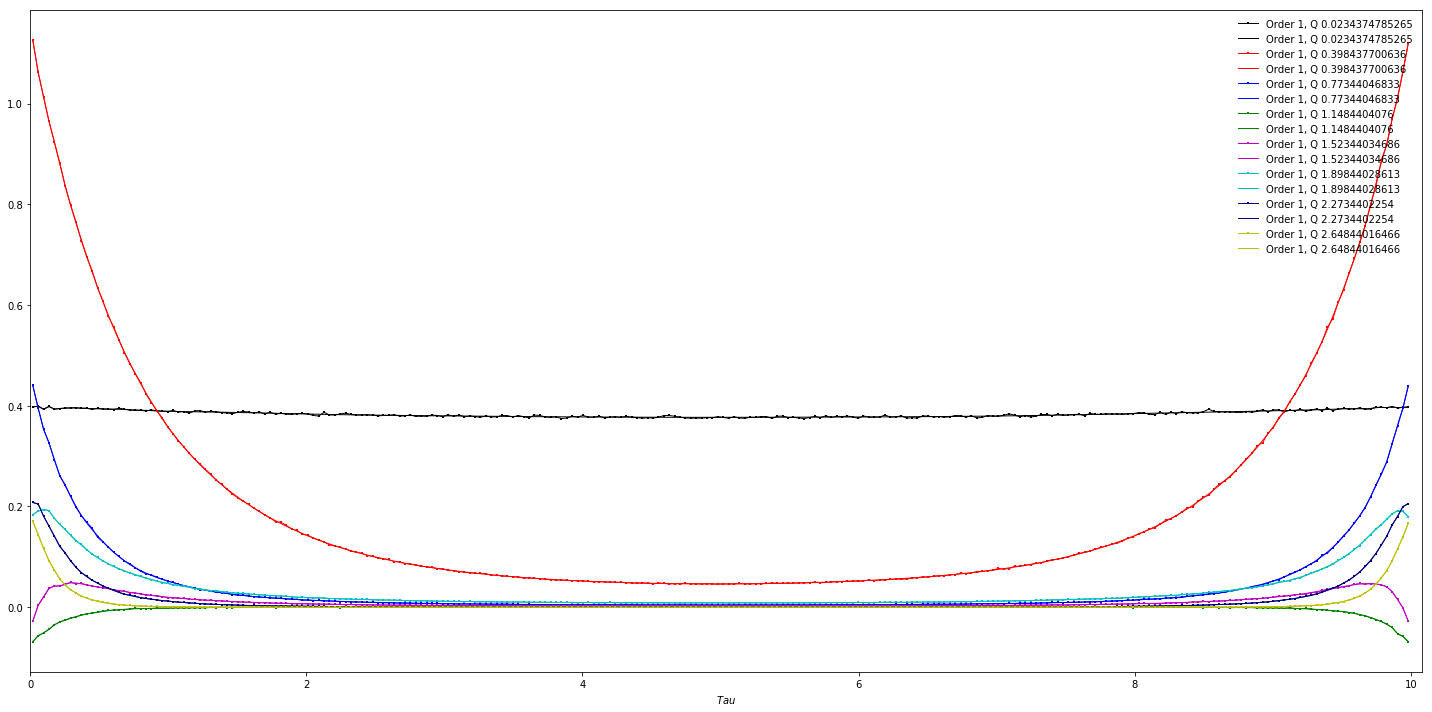

In [14]:
plt.show()